# Mo Ru Surrogate Model using Neural Networks

In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt

import sys
import mpmath
sys.modules['sympy.mpmath'] = mpmath

### Read and Dump JSON

In [2]:
import json

filename = '../data/MoRu_sparse.json'
stream = open(filename)
data = json.load(stream)
stream.close()

### Generate Dataset from JSON Dump

The dataset $\mathcal{D} \subset \mathbb{R}_{\ge 0}^{n_\text{samples} \times (n_\text{elements} + n_\text{phases} + 2)}$ is defined as:
$$\mathcal{D} = \{\mathbf{x}_i \, | \, i \in \{1, \dots, n_\text{samples}\}\}$$
where, $\mathbf{x}_i$ is a single sample such that:
$$\mathbf{x}_i = \left\{{T, P, \{c_j \, | \, j \in \mathcal{1, \dots, n_\text{elements}}\}, \{n_\phi \, | \, \phi \in \mathcal{1, \dots, n_\text{phases}}\}}\right\}$$
where, $c_j$ denotes number of moles of element $j$ and $n_\phi$ denotes the number of moles of phase $\phi$.

In [3]:
n_data = len(data)
n_elements = len(data['2']['elements'])
n_phases = len(data['2']['solution phases']) + len(data['2']['pure condensed phases'])
dataset = np.zeros((n_data, n_elements + n_phases + 2))

phase_names = list(data['2']['solution phases'].keys())
phase_names += list(data['2']['pure condensed phases'].keys())
element_names = list(data['2']['elements'].keys())

In [4]:
keys = list(data.keys())
for i in keys:
    dataset[keys.index(i), 0] = data[i]["temperature"]
    dataset[keys.index(i), 1] = data[i]["pressure"]

    for j in range(n_elements):
        if not (data[i]['elements'].get(element_names[j]) is None):
            dataset[keys.index(i), 2 + j] = data[i]["elements"][element_names[j]]["moles"]
        else:
            dataset[keys.index(i), 2 + j] = 0.0

    for j in range(n_phases):
        if not (data[i]['solution phases'].get(phase_names[j]) is None):
            dataset[keys.index(i), 2 + n_elements + j] = data[i]["solution phases"][phase_names[j]]["moles"]
        elif not (data[i]['pure condensed phases'].get(phase_names[j]) is None):
            dataset[keys.index(i), 2 + n_elements + j] = data[i]["pure condensed phases"][phase_names[j]]["moles"]
        else:
            dataset[keys.index(i), 2 + n_elements + j]

### Generate Training Data

- Training samples $n_\text{Train} = 0.6 * n_\text{Total}$
- Input $\mathbf{X} = {T, P, \mathbf{c}}$
- Output $\mathbf{y} = {\mathbf{n}_\phi}$

In [5]:
n_training = int(n_data * 0.6)

choice = np.random.choice(range(dataset.shape[0]), size=(n_training,), replace=False)
train_indices = np.zeros(dataset.shape[0], dtype=bool)
train_indices[choice] = True
test_indices = ~train_indices


train = dataset[train_indices]
test = dataset[test_indices]

X_train = train[:,0:(2 + n_elements)]

# Change the outputs to 0.0 / 1.0 based on the number of moles of phase
y_train = (train[:,(2 + n_elements):] > 0.0).astype(float)

# Use the original moles
# y_train = train[:,(2 + n_elements):]

In [6]:
# Convert to Torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_train_unscaled = X_train.detach().clone()
y_train = torch.tensor(y_train, dtype=torch.float32)
y_train_unscaled = y_train.detach().clone()

In [7]:
# Calculate mean and standard deviation of inputs
X_mean = X_train.mean(0,keepdim=True)
X_std = X_train.std(0,keepdim=True)

# Standard deviation of pressure is equal to 0.0. Change this to 1.0 to avoid division by zero when scaling
X_std[X_std == 0] = 1.0

# Scale inputs to mean 0 and standard deviation 1 for better convergence
X_train = (X_train - X_mean) / X_std

### Test Data

In [8]:
# Scale test input values to mean 0 and standard deviation 1 based on values from before
X_test_unscaled = torch.tensor(test[:,0:(2 + n_elements)], dtype=torch.float32)
X_test = (X_test_unscaled - X_mean) / X_std

# 0 / 1 Output case
y_test = (test[:,(2 + n_elements):] > 0.0).astype(float)

# Original moles of phase
# y_test = test[:,(2 + n_elements):]
y_test = torch.tensor(y_test, dtype=torch.float32)

# Combined test and training data
X_all_unscaled = torch.cat([X_train_unscaled, X_test_unscaled])
X_all = torch.cat([X_train, X_test])
y_all = torch.cat([y_train, y_test])

### Neural Network Model

In [9]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")

In [10]:
input_size = X_test.shape[1]
hidden_size = [10, 10]
output_size = y_test.shape[1]

model = nn.Sequential(
    nn.Linear(input_size, hidden_size[0]),
    nn.ReLU(),
    nn.Linear(hidden_size[0], hidden_size[1]),
    nn.ReLU(),
    nn.Linear(hidden_size[1], output_size),
    nn.Sigmoid())

In [11]:
loss_fn = nn.MSELoss()  # Mean Square Error
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training

In [12]:
n_epochs = 10000
batch_size = 100

for epoch in range(n_epochs):
    for i in range(0, len(X_train), batch_size):
        Xbatch = X_train[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = y_train[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 0.256915807723999
Finished epoch 1, latest loss 0.24953913688659668
Finished epoch 2, latest loss 0.2415258139371872
Finished epoch 3, latest loss 0.23253442347049713
Finished epoch 4, latest loss 0.2225121110677719
Finished epoch 5, latest loss 0.21157559752464294
Finished epoch 6, latest loss 0.19912166893482208
Finished epoch 7, latest loss 0.18591482937335968
Finished epoch 8, latest loss 0.17282937467098236
Finished epoch 9, latest loss 0.16017526388168335
Finished epoch 10, latest loss 0.14877387881278992
Finished epoch 11, latest loss 0.13890182971954346
Finished epoch 12, latest loss 0.13065201044082642
Finished epoch 13, latest loss 0.12395433336496353
Finished epoch 14, latest loss 0.1186094880104065
Finished epoch 15, latest loss 0.11441962420940399
Finished epoch 16, latest loss 0.11122468113899231
Finished epoch 17, latest loss 0.10894736647605896
Finished epoch 18, latest loss 0.10747745633125305
Finished epoch 19, latest loss 0.1064866632223

###  Evaluation

In [13]:
# Compute accuracy for NN data set
with torch.no_grad():
    y_pred = model(X_all)

diff = (y_pred - y_all)
accuracy =(diff**2).mean()**.5
delta_min = diff.min()
delta_max = diff.max()
print(f"NN Absolute RMS Accuracy {accuracy},  Min {delta_min}, Max {delta_max}")

NN Absolute RMS Accuracy 0.04287424683570862,  Min -0.9999982118606567, Max 1.0


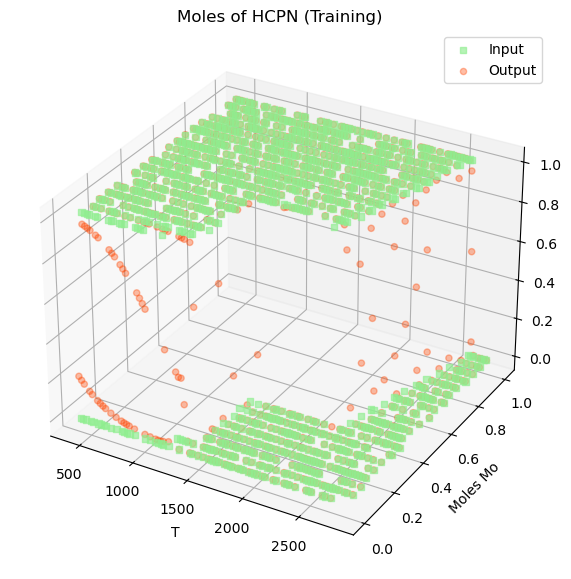

In [14]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Evaluate the model
with torch.no_grad():
    y_pred = model(X_train)

# Creating plot
ax.scatter3D(X_train_unscaled[:,0], X_train_unscaled[:,2], y_train_unscaled[:,5], marker = 's', color = "lightgreen", alpha = 0.65, label = "Input")
ax.scatter3D(X_train_unscaled[:,0], X_train_unscaled[:,2], y_pred[:,5], color = "orangered", alpha = 0.35, label = "Output")
plt.title("Moles of HCPN (Training)")
plt.xlabel("T")
plt.ylabel("Moles Mo")
plt.legend()
plt.show()

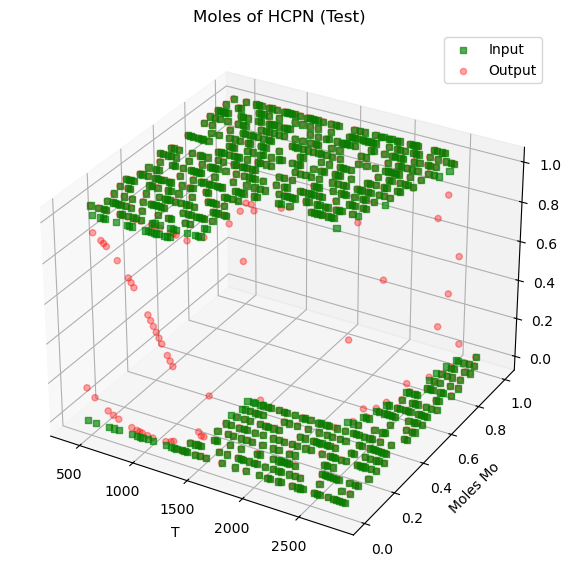

In [15]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Evaluate the model
with torch.no_grad():
    y_pred = model(X_test)

# Creating plot
X_test_unscaled = X_test * X_std + X_mean
ax.scatter3D(X_test_unscaled[:,0], X_test_unscaled[:,2], y_test[:,5], marker = 's', color = "green", alpha = 0.65, label = "Input")
ax.scatter3D(X_test_unscaled[:,0], X_test_unscaled[:,2], y_pred[:,5], color = "red", alpha = 0.35, label = "Output")
plt.title("Moles of HCPN (Test)")
plt.xlabel("T")
plt.ylabel("Moles Mo")
plt.legend()
plt.show()


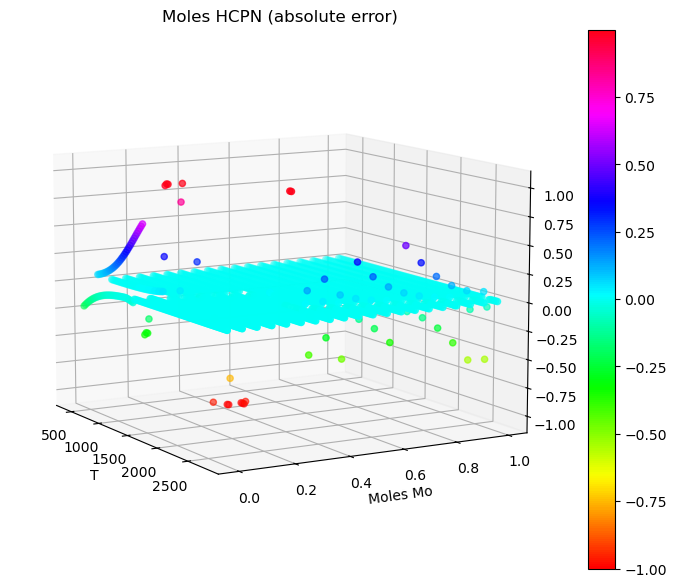

In [16]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.view_init(elev=10, azim=-30, roll=0)

# Evaluate the model
with torch.no_grad():
    y_pred1 = model(X_train)
    y_pred2 = model(X_test)

# NN error
y_pred = torch.cat([y_pred1, y_pred2])
y_err = (y_all - y_pred)

sc = ax.scatter3D(X_all_unscaled[:,0], X_all_unscaled[:,2], y_err[:,5], c=y_err[:,5], cmap='hsv')
fig.colorbar(sc, ax=ax)

plt.title("Moles HCPN (absolute error)")
plt.xlabel("T")
plt.ylabel("Moles Mo")
plt.show()